# Задание 2


При применении последовательного алгоритма перемножения матриц число шагов имеет порядок $O(n^3)$.

Для параллельного алгоритма на каждой итерации каждый процессор выполняет умножение имеющихся на процессоре полос исходных матриц А и В (размерность каждой полосы составляет $n/p$, следовательно, общее количество выполняемых при этом умножении операций равно $n^3/p^2$). 

Поскольку число итераций алгоритма совпадает с количеством процессоров, сложность параллельного алгоритма без учета затрат на передачу данных может быть определена при помощи выражения:
$$
T_p = \frac{n^3}{p^2}\,p = \frac{n^3}{p}
$$

Показатели ускорения и эффективности данного параллельного алгоритма:
$$
S = T_s/T_p = n^3 / ( n^3 / p) = p
$$

$$
E = \frac{n^3}{( n^3 / p) \cdot p} = 1
$$

Это - идеальные показатели.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [36]:
df_all = pd.read_csv('results.csv', sep=';')
df_all.head()

,n,p,time
0,30,2,0.025409
1,60,2,0.171784
2,80,2,0.418165
3,30,3,0.012445
4,60,3,0.094091


In [37]:
df_all.p -= 1

In [38]:
#df_all.p = df_all.p.max() - df_all.p

## Ускорение и закон Амдаля

In [39]:
for n in df_all.n.unique():
    for p in df_all.p.unique():
        df_all.loc[(df_all.p==p)&(df_all.n==n),'mean_time'] = df_all[(df_all.p==p)&(df_all.n==n)]['time'].mean()

In [40]:
df = df_all
df

,n,p,time,mean_time
0,30,1,0.025409,0.024387
1,60,1,0.171784,0.175043
2,80,1,0.418165,0.404159
3,30,2,0.012445,0.013009
4,60,2,0.094091,0.098190
...,...,...,...,...
415,60,13,0.038694,0.038977
416,80,13,0.085782,0.086086
417,30,14,0.007220,0.007136
418,60,14,0.033449,0.033587


In [41]:
for n in df.n.unique():
    for p in df.p.unique():
        p_1_time = (df[(df.n==n)&(df.p==1)]['mean_time']).iloc[0]
        own_time = df[(df.p==p)&(df.n==n)]['mean_time'].iloc[0]
        df.loc[(df.p==p)&(df.n==n),'accel'] = p_1_time/own_time

In [42]:
df['eff'] = df['accel']/df['p']

In [43]:
df[df.n == 30]

,n,p,time,mean_time,accel,eff
0,30,1,0.025409,0.024387,1.000000,1.000000
3,30,2,0.012445,0.013009,1.874647,0.937323
6,30,3,0.010748,0.009953,2.450219,0.816740
9,30,4,0.007880,0.007603,3.207518,0.801879
12,30,5,0.006494,0.006612,3.688454,0.737691
...,...,...,...,...,...,...
405,30,10,0.007881,0.007614,3.202757,0.320276
408,30,11,0.005841,0.005738,4.250416,0.386401
411,30,12,0.006014,0.005710,4.270646,0.355887
414,30,13,0.006971,0.006905,3.531794,0.271676


## Аппроксимации ускорений

In [44]:
def amdal(p, f):
    return 1/(f + (1-f)/p)
def gustav(n, s):
    return n + (1-n)*s

In [45]:
def plot_save_graphs(x_label, y_label, fixed='p'):
    
    def _appr_accel(n, p):
        # TODO: place here theoretical approximation
        #return 6*n/(6*n/p + 6 + np.log2(p))
        return n/n*p
    
    def _appr_eff(n, p):
        return _appr_accel(n, p)/p
    
    def _appr_gustav(n, p, accels):
        '''
        if len(np.array(o).reshape(-1)) == 1:
            n = np.array([n]*len(accels))
        elif len(np.array(accels).reshape(-1)) == 1:
            accels = np.array([accels]*len(n))
        '''
        from scipy.optimize import curve_fit
        popt, pcov = curve_fit(gustav, n, accels)
        return gustav(n, popt[0]).iloc[-1]*n/n
    
    def _appr_amdal(n, p, accels):
        if len(np.array(p).reshape(-1)) == 1:
            p = np.array([p]*len(accels))
        elif len(np.array(accels).reshape(-1)) == 1:
            accels = np.array([accels]*len(p))
        from scipy.optimize import curve_fit
        popt, pcov = curve_fit(amdal, p, accels)
        return amdal(p, popt[0])
    
    def _routine(data, x_label, y_label, fixed_value):
        x_data, y_data = data[x_label], data[y_label]
        plt.scatter(x_data, y_data, label='real')
        p, n = (fixed_value, x_data)
        if x_label == 'p':
            p, n = (n, p)
        # Approximation
        if y_label == 'accel':
            plt.scatter(x_data, _appr_accel(n, p), color='red', label='theor')
            if x_label == 'p':
                plt.scatter(x_data, _appr_amdal(n, p, y_data), color='green', label='amdal')
            else:
                plt.scatter(x_data, _appr_gustav(n, p, y_data), color='grey', label='gustav')
        elif y_label == 'eff':
            plt.scatter(x_data, _appr_eff(n, p), color='red', label='theor')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.title(f'{y_label}, {fixed}={fixed_value}')
        plt.savefig(f'{y_label}_{fixed}_{fixed_value}', dpi=120)
        plt.show()
    if fixed == 'n':
        for n in df.n.unique():
            data = df[df.n==n]
            _routine(data, x_label, y_label, n)
    elif fixed == 'p':
        for p in df.p.unique():
            data = df[df.p==p]
            _routine(data, x_label, y_label, p)
    else:
        raise ValueError('Not implemented')

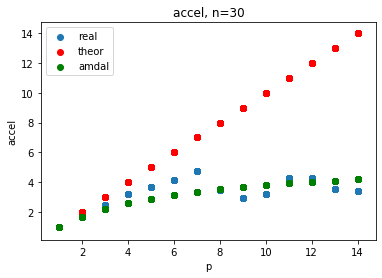

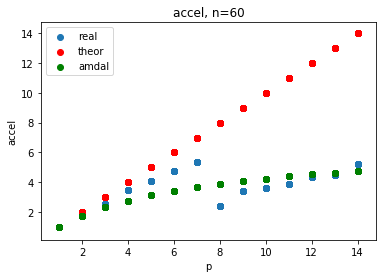

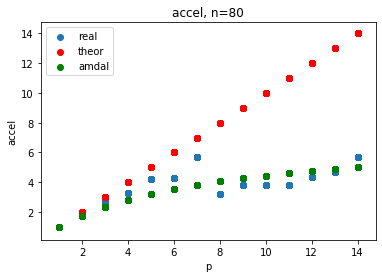

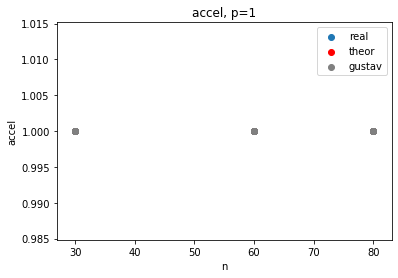

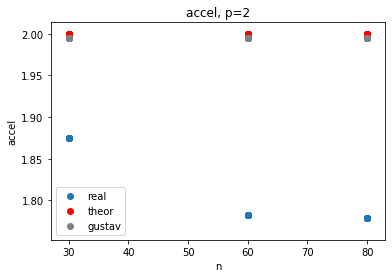

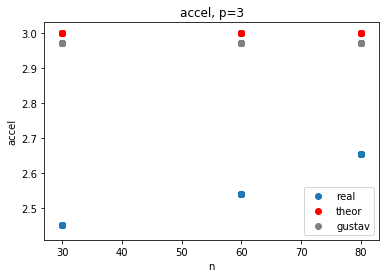

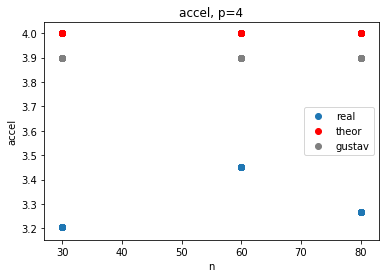

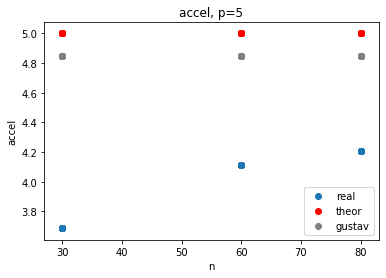

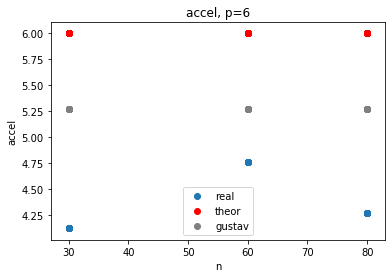

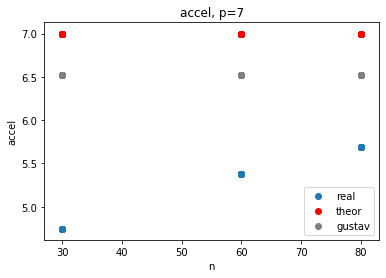

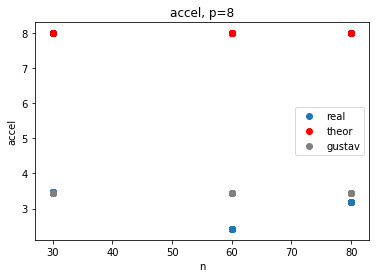

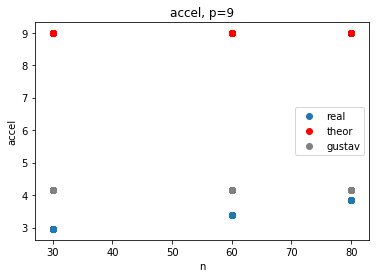

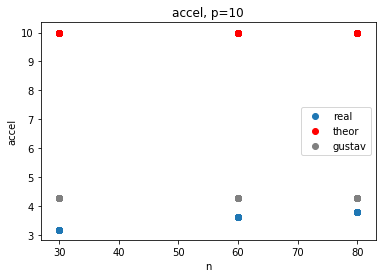

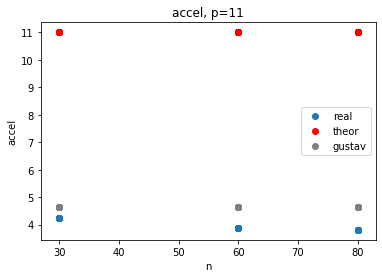

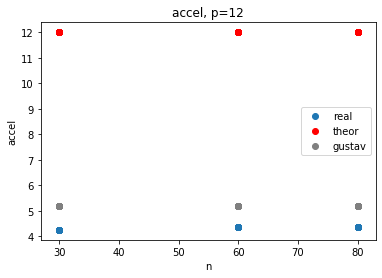

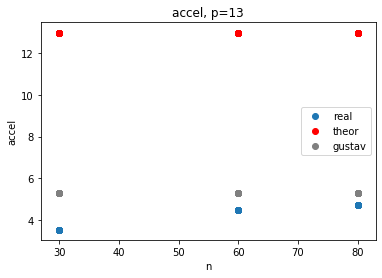

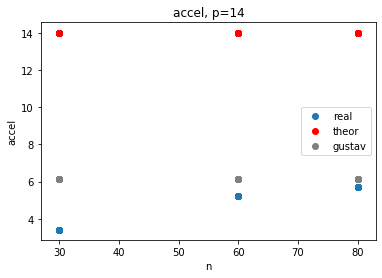

In [47]:
plot_save_graphs('p', 'accel', fixed='n')
plot_save_graphs('n', 'accel', fixed='p')
#plot_save_graphs('p', 'eff', fixed='n')
#plot_save_graphs('n', 'eff', fixed='p')

БОНУС: неидеальные оценки
    
Время вычисления (оценка):
$$
T_p (calc) =  \frac{n^2}{p} (2 n - 1) t,
$$
где t - время выполнения одной элементарной скалярной операции.

Будем предполагать, что все операции передачи данных между процессорами в ходе одной итерации алгоритма могут быть выполнены параллельно. Объем передаваемых данных между процессорами определяется размером полос и составляет $n/p$ строк или столбцов длины $n$. Общее количество параллельных операций передачи сообщений на 1 меньше числа итераций алгоритма (на последней итерации передача данных не является обязательной). Тогда:

$$
T_p (comm) = (p - 1) (a + w n ( n / p ) / b ),
$$ где $a$ - постоянная задержка (латентность), $b$ - пропускная способность сети передачи данных, а $w$ - размер элемента матрицы в байтах. Тогда

$$
    T_p = \frac{n^2}{p} \left(2n - 1\right) t + (p - 1) \left(a + w n \frac{n}{pb}\right)
$$

Здесь параметрами выступают $a$, $b$, $t$. В случае типа `np.float` $w = 8$